# *Image processing of corroded pit - part 2: analysis of crystal sediments*

- By [Gianluca Iori](https://github.com/gianthk), Giulia Franceschin, Roberta Zanin, Elena Longo, 2022
- Code licence: MIT
- Narrative licence: CC-BY 
- How to cite: *Specify how you want people to cite this notebook. You can refer to a publication or a repository (e.g. link your GitHub repository to Zenodo - see [this video](https://www.youtube.com/watch?v=gp3D4mf6MHQ))*
- Created on:  22.04.2022
- Last update: 13.02.2023

---
# Aims
Generate triangle mesh of one crystal deposit

---
# *Computational workflow*

## Configuration and imports

In [2]:
import sys
sys.path.append('./../../recon_utils')
# sys.path.append('/home/gianthk/PycharmProjects/CT2FE')

Configure working folder (change this to your local path)

In [4]:
work_folder = "/run/media/beats/My Passport/20217193_Traviglia/recons/581681_punta_HR_stitch2_merge_corr_phrt"
# work_folder = '/media/gianthk/My Passport/20217193_Traviglia/recons/581681_punta_HR_stitch2_merge_corr_phrt'
# work_folder = '/home/gianthk/Data/BEATS/Franceschin/20217193_Traviglia/recons/581681_punta_HR_stitch2_merge_corr_phrt'

In [5]:
import numpy as np
import meshio
import mcubes
from recon_utils import read_tiff_stack, plot_midplanes

astropy module not found
olefile module not found


Matplotlib plotting configuration

## Load crystal mask

In [7]:
input_file = work_folder+'/masks/crystal/slice_00.tif'

In [8]:
crystal_BW = read_tiff_stack(input_file)

Voxelsize:

In [9]:
vs = np.ones(3)*1.0e-3 # [mm]

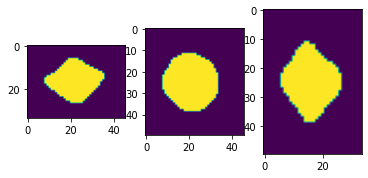

In [10]:
# Inspect slice
plot_midplanes(crystal_BW)

## Compute outer mesh of triangles

In [11]:
vertices, triangles = mcubes.marching_cubes(np.transpose(mcubes.smooth(crystal_BW>=1), [2, 1, 0]), 0.5)

## Save the mesh
write VTK mesh with meshio

In [12]:
filename_mesh_out = work_folder+'/masks/crystal.vtk'
meshio.write_points_cells(filename_mesh_out, vertices.tolist(), [("triangle", triangles.tolist())])

![1crystal](crystal.png)

---
# Acknowledgements
-  The authors acknowledge the [CERIC-ERIC](https://www.ceric-eric.eu/) Consortium for the access to experimental facilities and financial support